In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from iminuit import Minuit
from iminuit.cost import LeastSquares

def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

In [7]:
with open('../../genIII_data/JLab/Beam/Beam1_0-Cal.pkl', 'rb') as file:
    # Load the data from the pickle file
    beam_data = pickle.load(file)
    
e_cut = 0.3

In [48]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2. * sigma ** 2))

def layer_energy_sums(beam_data, target_layer):
    positions = beam_data['positions']  # shape: (num_channels, 5)
    events = beam_data['events']        # shape: (num_events,), each item: (num_channels,)

    layer_mask = positions[:, 3] == target_layer  # index 3 is 'layer'

    # For each event, apply the layer mask and threshold
    return np.array([
        event[layer_mask][event[layer_mask] > e_cut].sum()
        for event in events
    ])

def channel_energy_values(beam_data, target_layer, target_channel):
    positions = beam_data['positions']  # shape: (num_channels, 5)
    events = beam_data['events']        # shape: (num_events,), each event is (num_channels,)

    # Extract columns: index 3 is layer, index 4 is channel number
    layer_mask = positions[:, 3] == target_layer
    ch_mask = positions[:, 4] == target_channel

    combined_mask = layer_mask & ch_mask

    if not np.any(combined_mask):
        raise ValueError(f"No channel found for layer {target_layer} and channel {target_channel}")

    idx = np.flatnonzero(combined_mask)[0]  # Should only be one

    return np.array([event[idx] for event in events])

def plot_layer_histograms(beam_data, layer_number, bins=40):
    configure_plotting()
    rows, cols = 5, 5
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(25):
        ch = 24 - i  # Invert channel order so 0 is bottom right, 24 is top left
        ax = axes[i]
        try:
            energies = channel_energy_values(beam_data, layer_number, ch)

            counts, bin_edges = np.histogram(energies, bins=bins, range=[0, 40])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            errors = np.sqrt(counts)

            ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Ch {ch}')
            ax.set_ylim(1, 14000)
            ax.set_yscale('log')
            ax.legend(fontsize=8)
        except ValueError:
            ax.set_visible(False)  # Hide subplot if channel doesn't exist

    # Label only bottom row and left column
    for ax in axes[-cols:]:
        ax.set_xlabel("Energy [MIP]", fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel("Counts", fontsize=10)
        
    for i, ax in enumerate(axes):
        if i % cols != 0:  # Not the last column (rightmost)
            ax.set_yticklabels([])  # Hide y-tick labels for non-leftmost columns
        if i < (cols * (rows - 1)):  # Not the bottom row
            ax.set_xticklabels([])  # Hide x-tick labels for non-bottom rows

    plt.suptitle(f"Layer {layer_number}", fontsize=18, y=1.02)
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def plot_all_layers(beam_data, bins=40):
    configure_plotting()
    # Set the number of layers and grid size for subplots
    num_layers = 15
    rows, cols = 3, 5  # 3 rows and 5 columns of subplots
    
    # Create a figure with subplots for all 15 layers
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for layer_number in range(num_layers):
        ax = axes[layer_number]
        
        # Get the energy values for the given layer
        try:
            energies = layer_energy_sums(beam_data, layer_number)
            
            # Plot histogram
            counts, bin_edges = np.histogram(energies, bins=bins, range=[0, 100])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            errors = np.sqrt(counts)
            
            ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Layer {layer_number}')
            ax.set_ylim(1, 4000)
            ax.set_yscale('log')
            ax.set_title(f'Layer {layer_number}', fontsize=10)
            ax.legend(fontsize=8)
        except ValueError:
            ax.set_visible(False)  # Hide subplot if no valid energy data for this layer

    for ax in axes[-cols:]:
        ax.set_xlabel("Energy [MIP]", fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel("Counts", fontsize=10)
        
    for i, ax in enumerate(axes):
        if i % cols != 0:  # Not the last column (rightmost)
            ax.set_yticklabels([])  # Hide y-tick labels for non-leftmost columns
        if i < (cols * (rows - 1)):  # Not the bottom row
            ax.set_xticklabels([])

    plt.suptitle(f"Energy Distributions for Layers 0-14", fontsize=18, y=1.02)
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def total_event_energies(beam_data):
    events = beam_data['events']  # shape: (num_events,), each item: (num_channels,)

    return np.array([
        event[event > e_cut].sum()
        for event in events
    ])




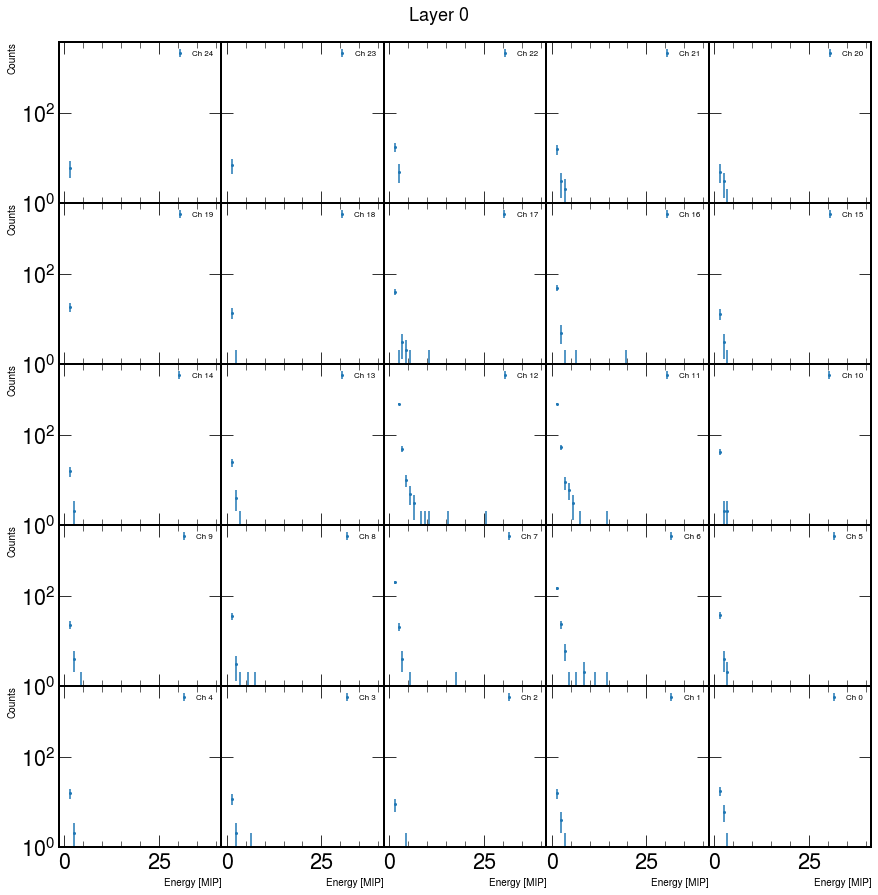

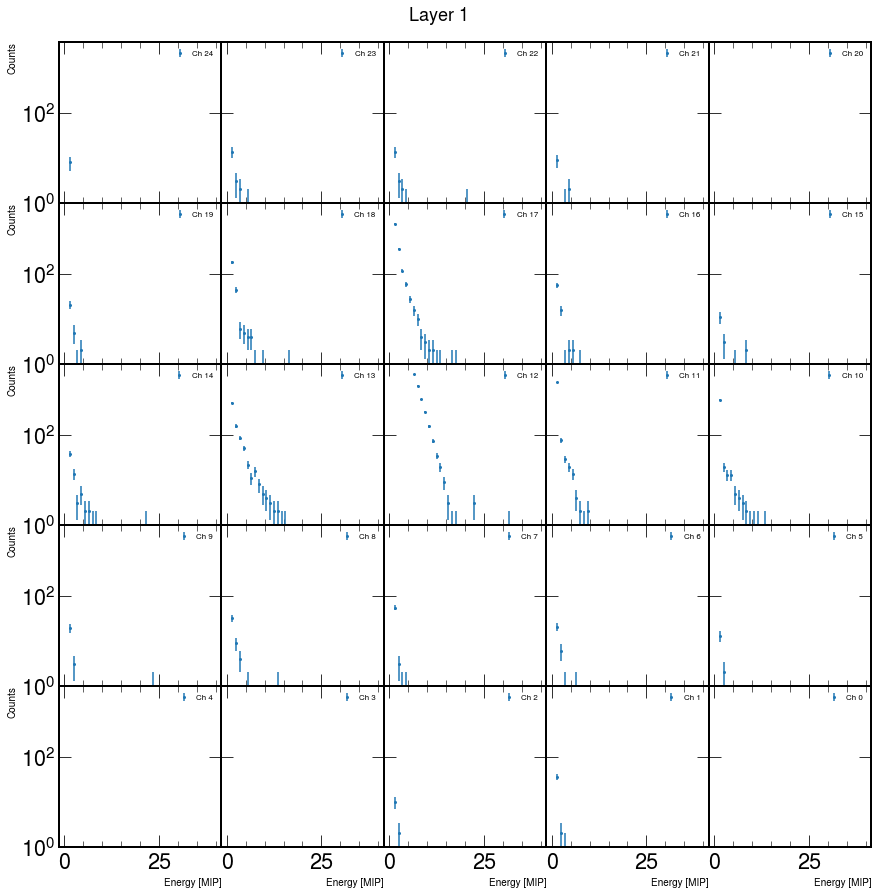

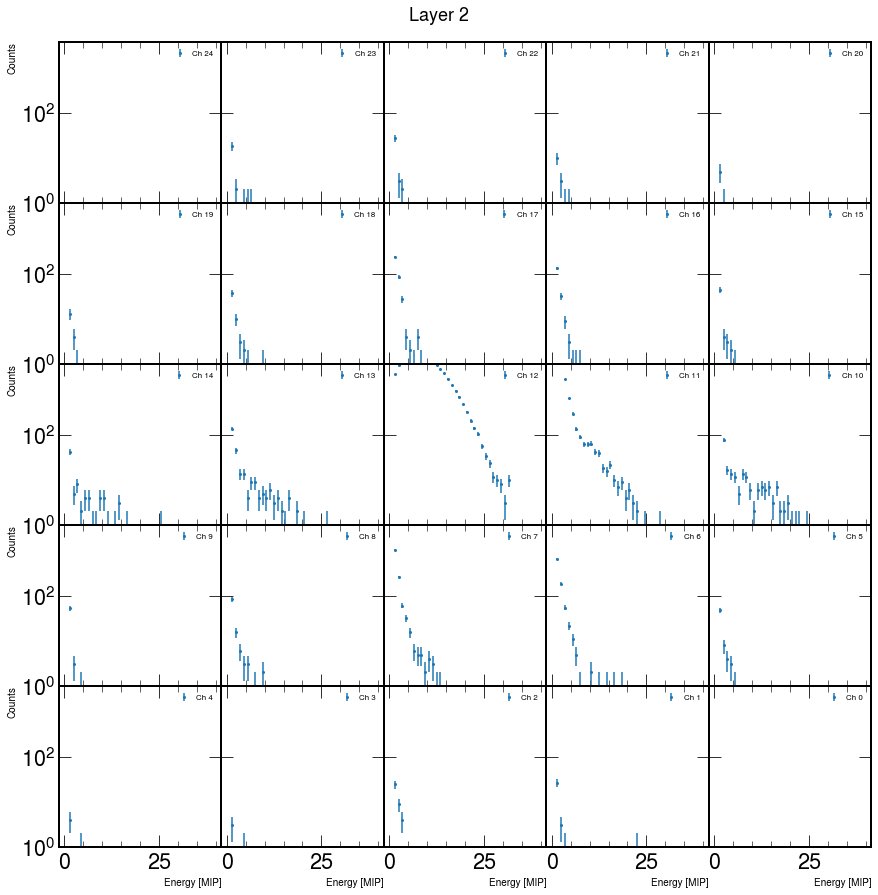

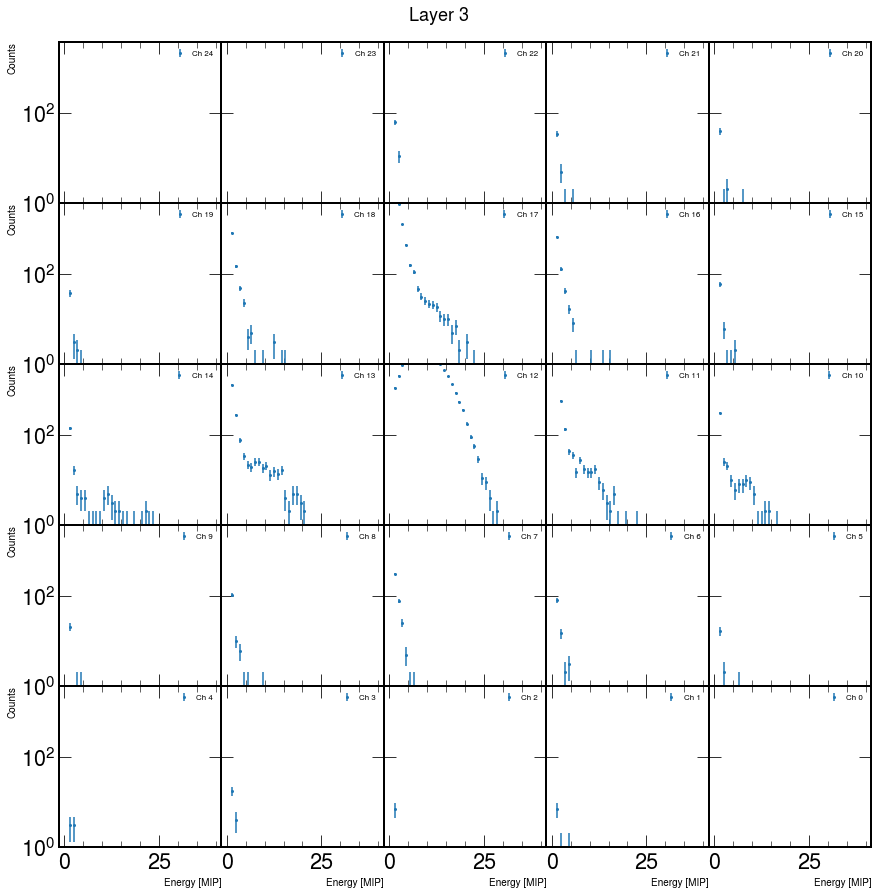

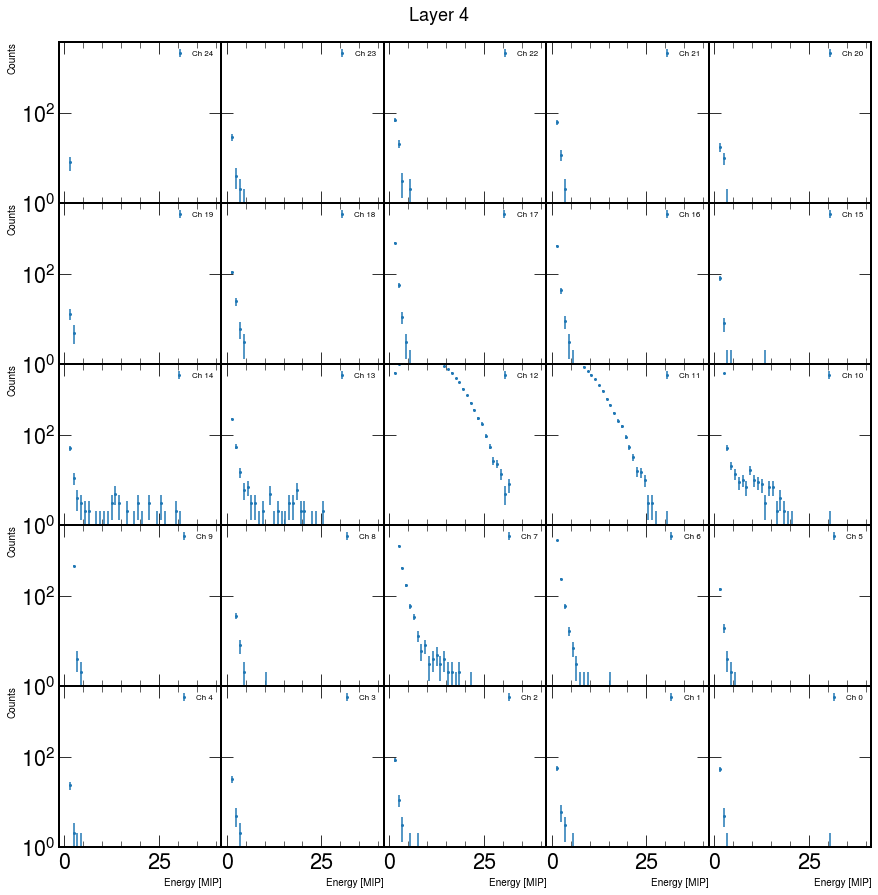

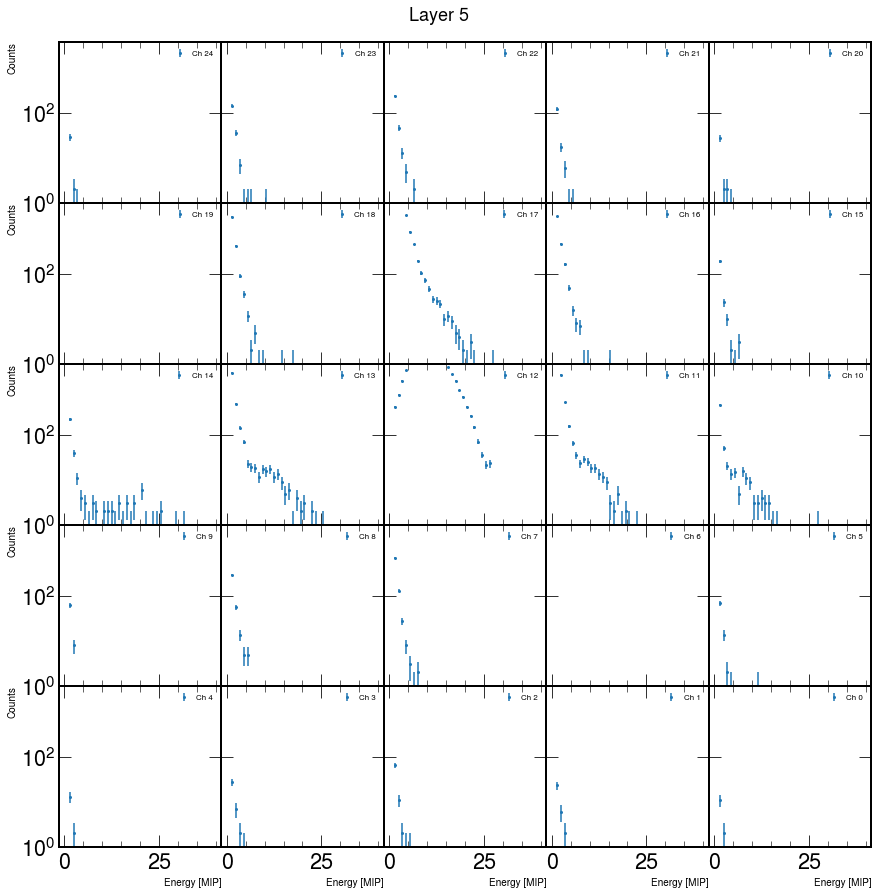

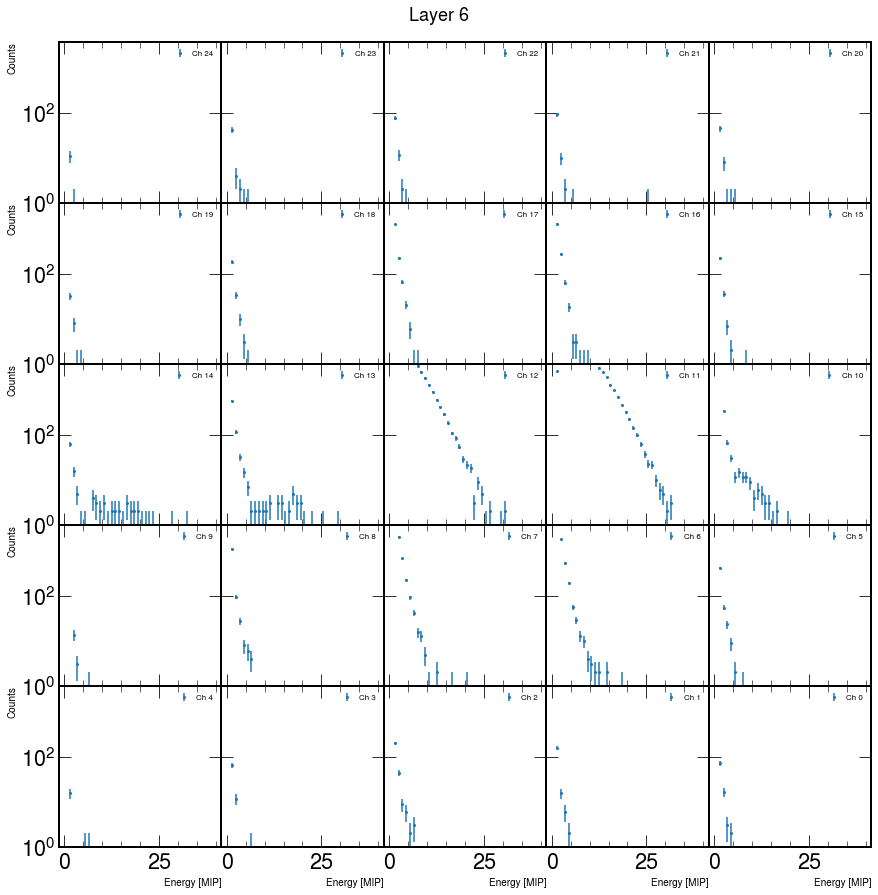

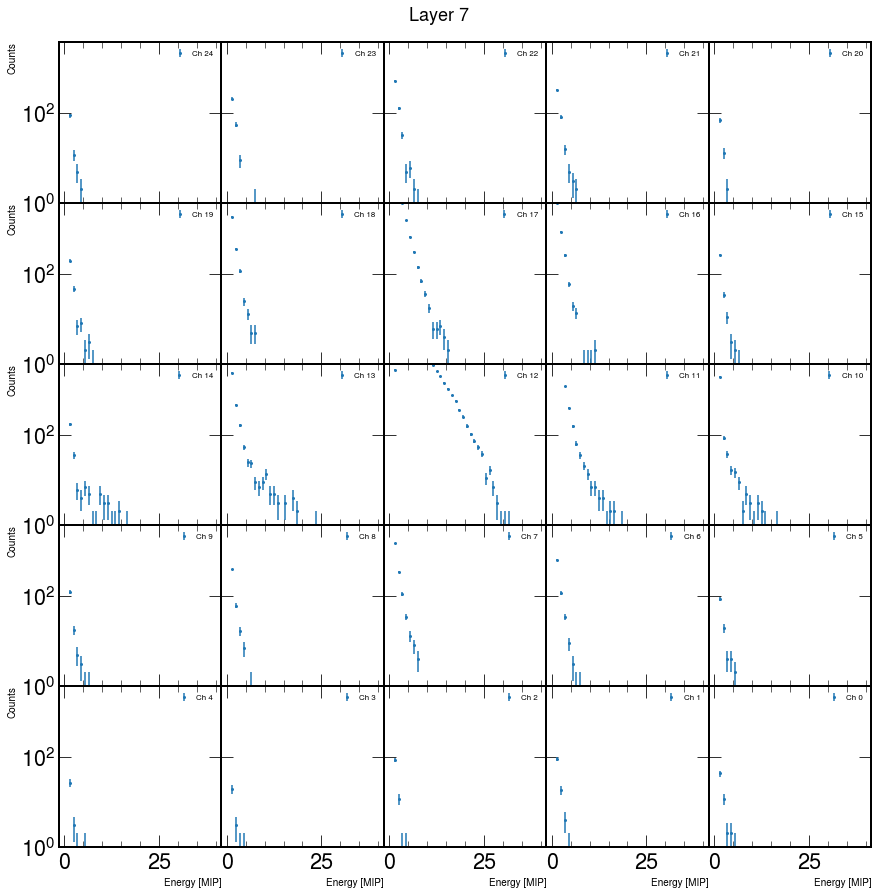

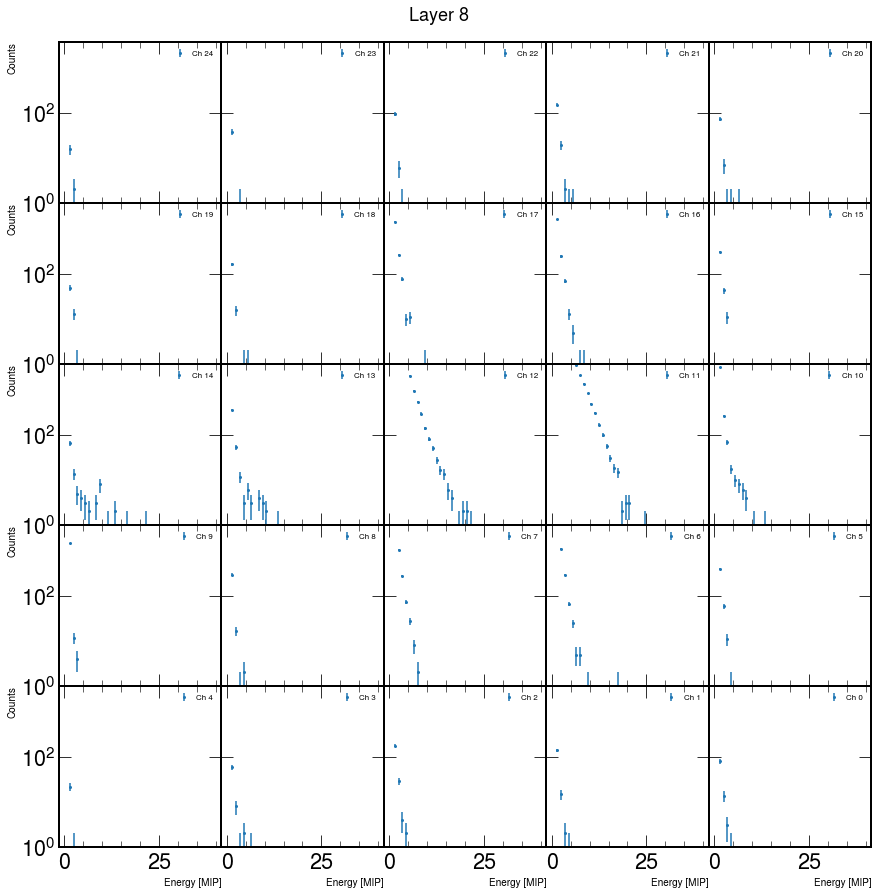

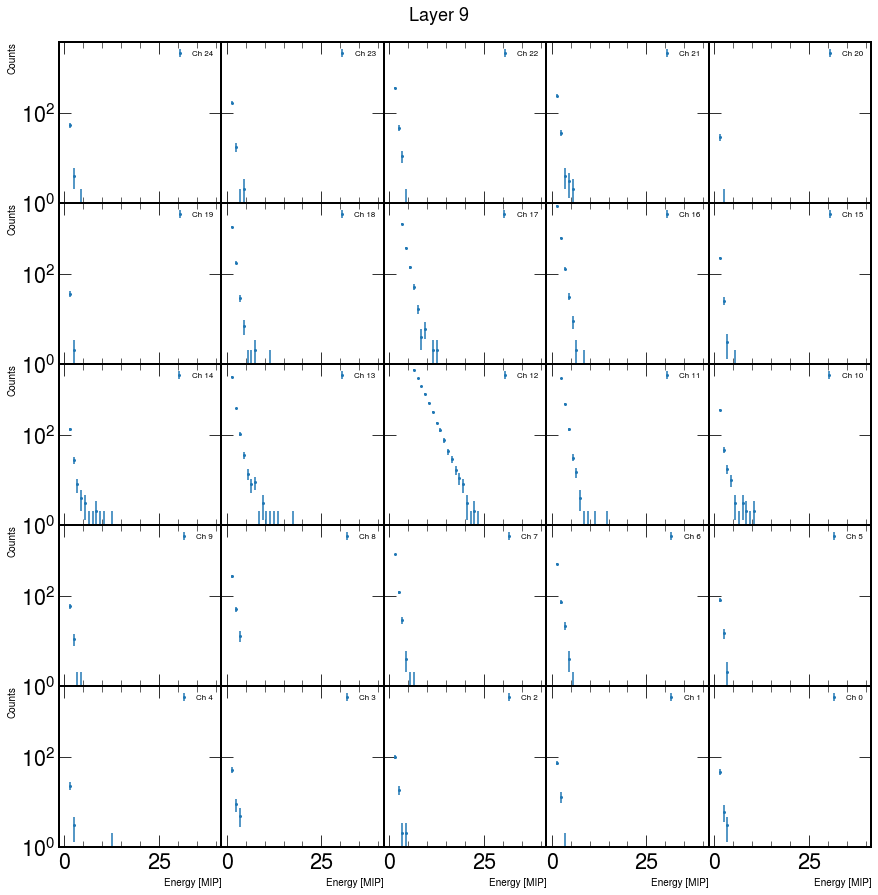

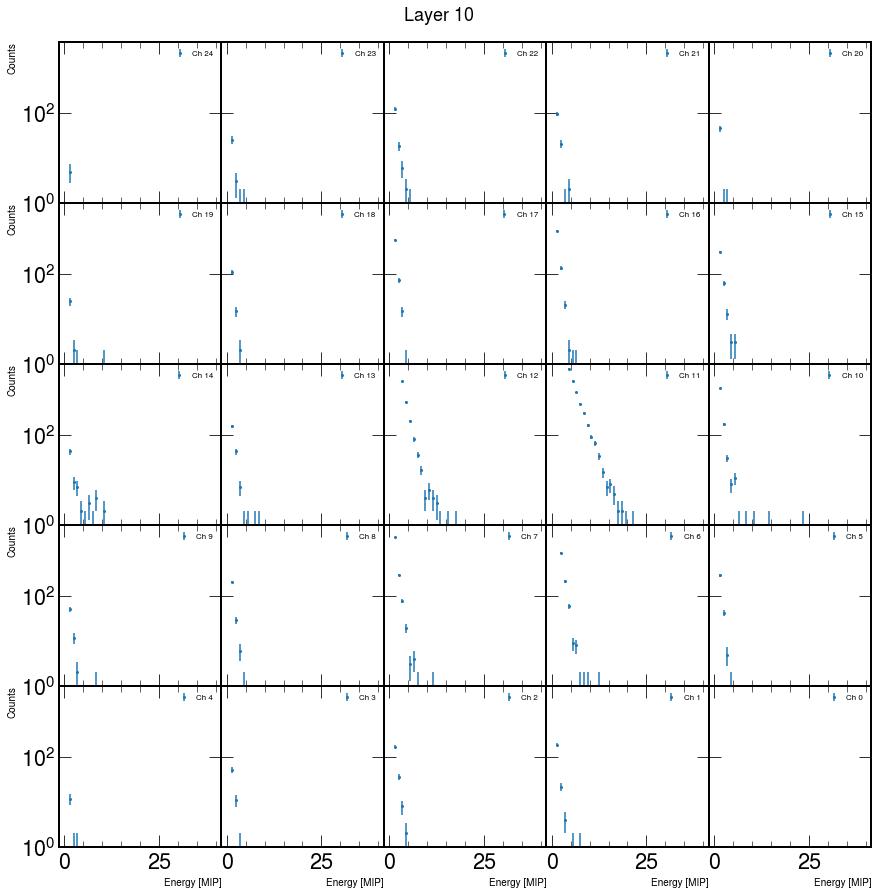

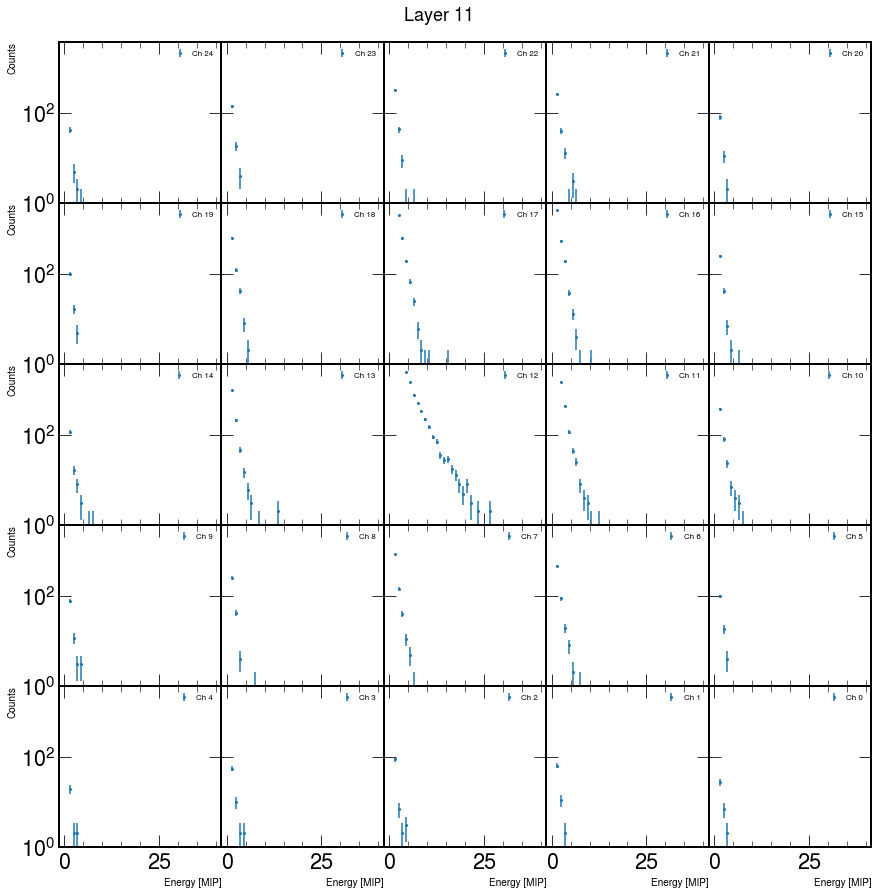

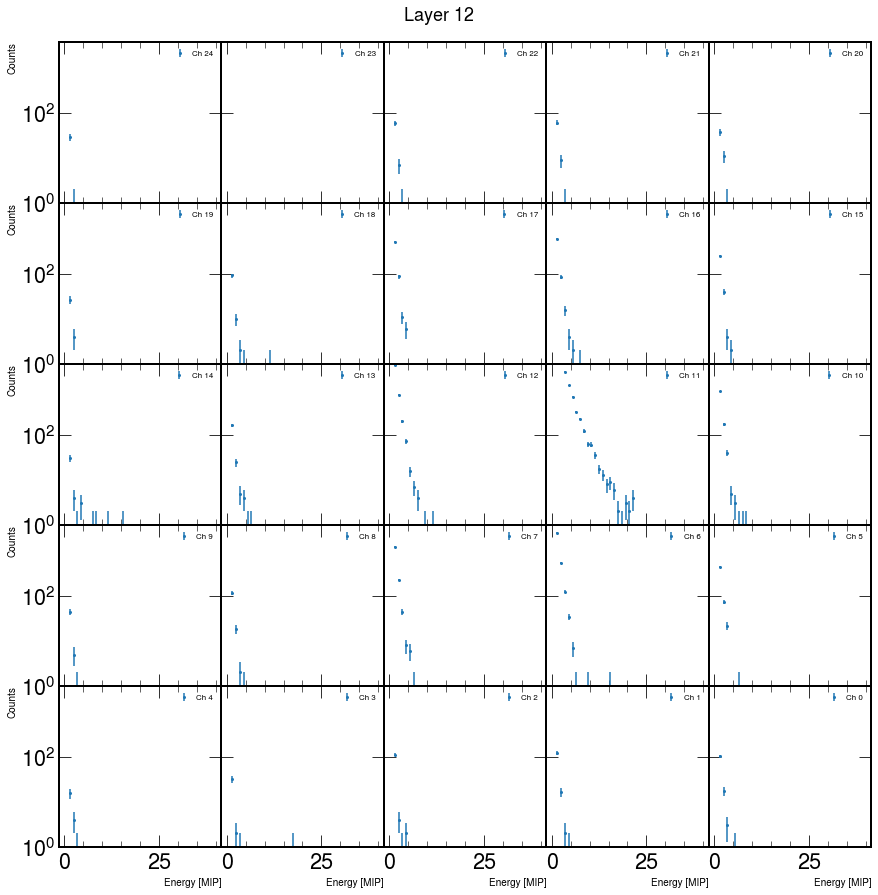

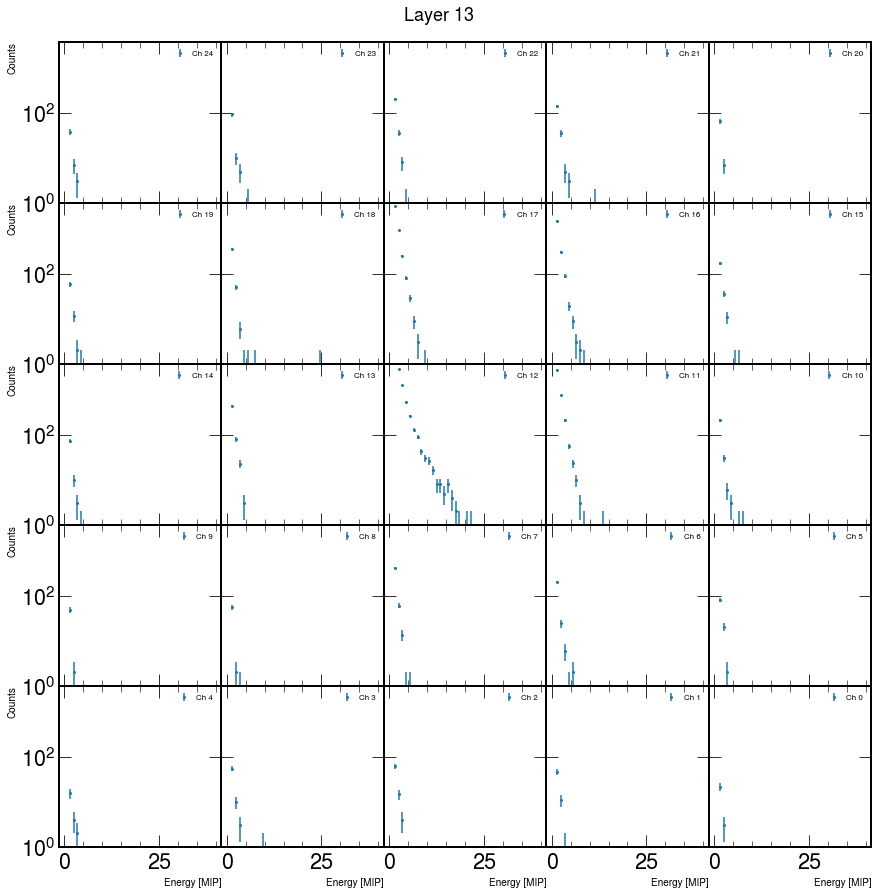

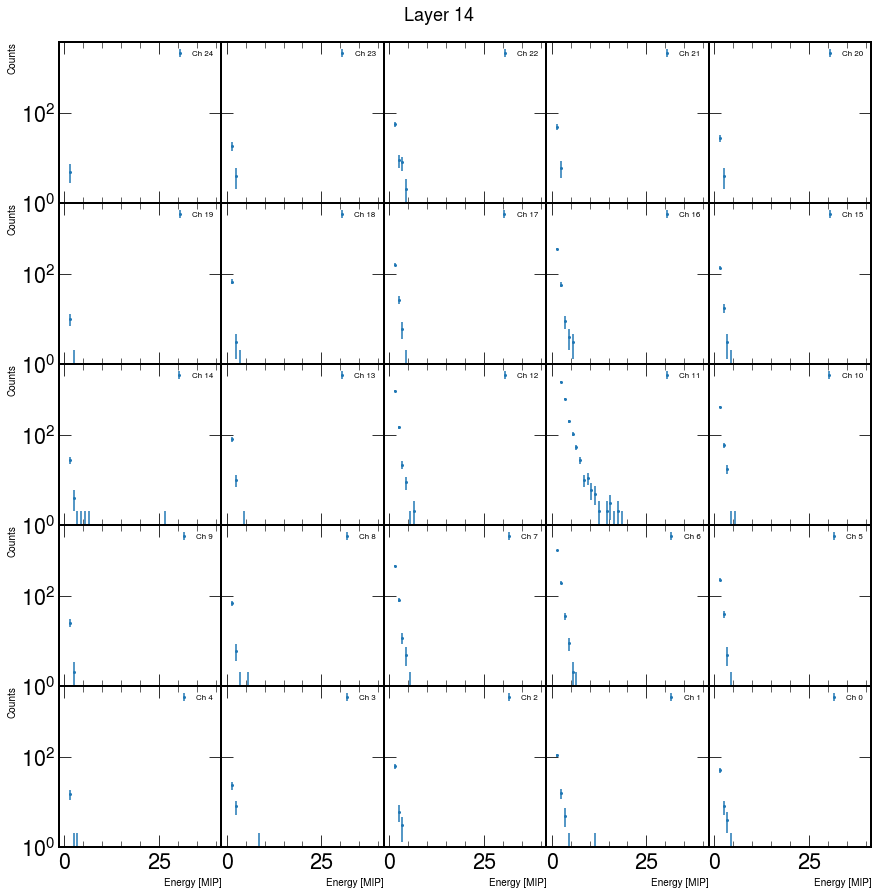

In [37]:
for i in range(15):
    plot_layer_histograms(beam_data, i, bins=40)

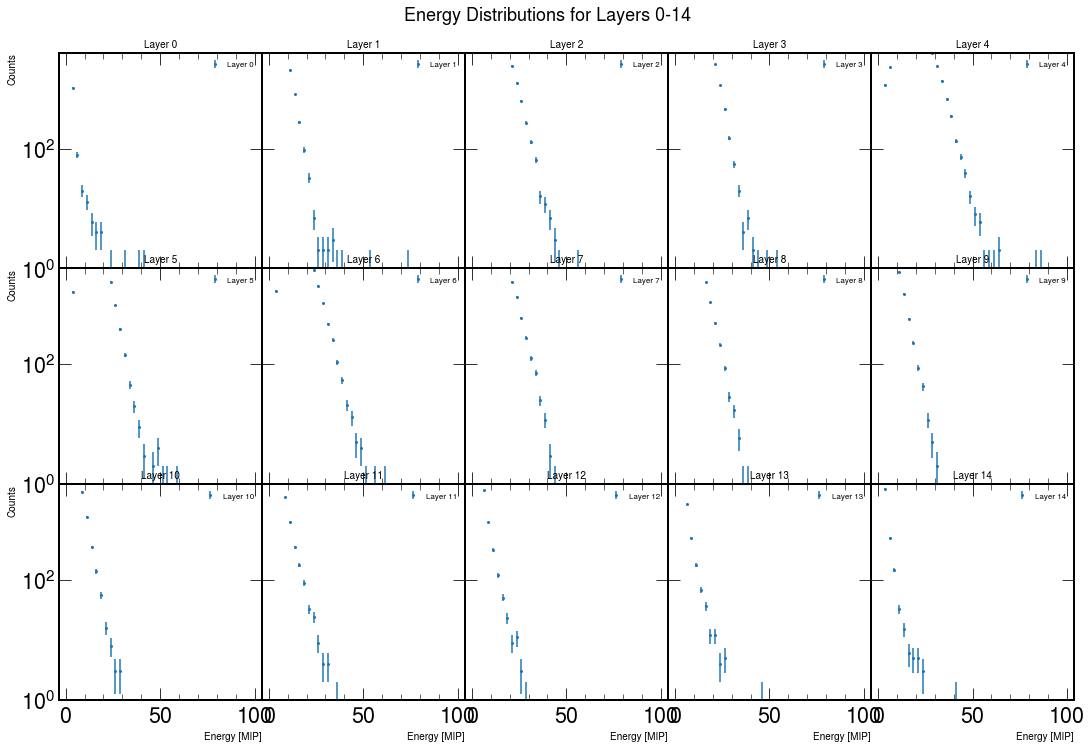

In [38]:
plot_all_layers(beam_data)

In [ ]:
energies = total_event_energies(beam_data)

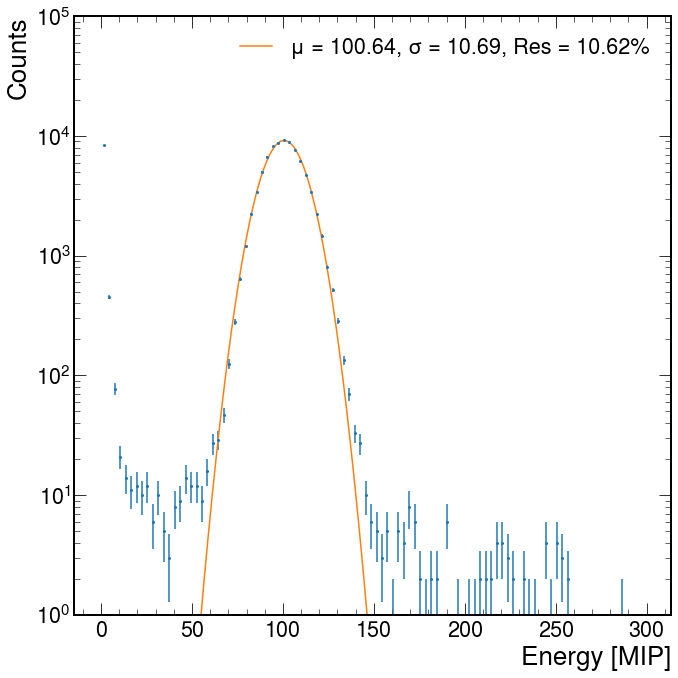

In [56]:
def plot_energy_histogram(data, bins=100, x_range=(0, 100), xlabel="Energy [MIP]", ylabel="Counts"):
    configure_plotting()
    counts, bin_edges = np.histogram(data, bins=bins, range=x_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)

    #plt.figure(figsize=(6, 4))
    plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2)
    
    # Only use bins with data for fitting
    mask = counts > 0
    x_data = bin_centers[mask]
    y_data = counts[mask]
    fit_errors = errors[mask]

    # Fit with Minuit
    initial_params = [max(y_data), np.mean(data[data>50]), np.std(data[data>50])]
    least_squares = LeastSquares(x_data, y_data, fit_errors, gauss)
    m = Minuit(least_squares, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.migrad()

    # Extract results
    fit_vals = m.values
    fit_errs = m.errors
    A_fit = fit_vals['A']
    mu_fit = fit_vals['mu']
    sigma_fit = fit_vals['sigma']
    fit_x = np.linspace(0, 200, 1500)
    fit_y = gauss(fit_x, A_fit, mu_fit, sigma_fit)
    resolution = (sigma_fit / mu_fit) * 100
    plt.plot(fit_x, fit_y, color='tab:orange',
         label=f"μ = {mu_fit:.2f}, σ = {sigma_fit:.2f}, Res = {resolution:.2f}%")
    plt.legend()
    plt.yscale('log')
    plt.ylim(1,100000)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()
    
plot_energy_histogram(energies, bins=100, x_range=(0, 300))

In [126]:
def event_energy_and_center_of_gravity(beam_data):
    positions = beam_data['positions']  # shape: (num_channels, 5) with x, y, z, layer, ch
    events = beam_data['events']        # list of (num_channels,) arrays

    results = []

    for event in events:
        event = np.asarray(event)
        mask = event > e_cut

        if np.count_nonzero(mask) == 0:
            results.append((0.0, np.nan, np.nan, np.nan))
            continue

        energies = event[mask]
        xs, ys, zs = positions[mask, 0], positions[mask, 1], positions[mask, 2]

        energy_sum = energies.sum()
        cog_x = np.average(xs, weights=energies)
        cog_y = np.average(ys, weights=energies)
        cog_z = np.average(zs, weights=energies)

        results.append((energy_sum, cog_x, cog_y, cog_z))

    return np.array(results, dtype=[('energy_sum', 'f4'), ('x', 'f4'), ('y', 'f4'), ('z', 'f4')])


In [141]:
def plot_cog(cog_data, bins=50, ranges=None):
    configure_plotting()
    valid = ~np.isnan(cog_data['x'])
    x_vals = cog_data['x'][valid]
    y_vals = cog_data['y'][valid]
    z_vals = cog_data['z'][valid]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for ax, vals, label, rng in zip(
        axes, [x_vals, y_vals, z_vals], ['X', 'Y', 'Z'],
        ranges if ranges else [None, None, None]
    ):
        counts, bin_edges = np.histogram(vals, bins=bins, range=rng)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts)

        ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=3)
        ax.set_title(f'Center of Gravity - {label}')
        ax.set_xlabel(f'{label} [mm]')
        ax.set_ylabel('Counts')
        ax.set_yscale('log')
        ax.set_ylim(10,40000)
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
cog_data = event_energy_and_center_of_gravity(beam_data)

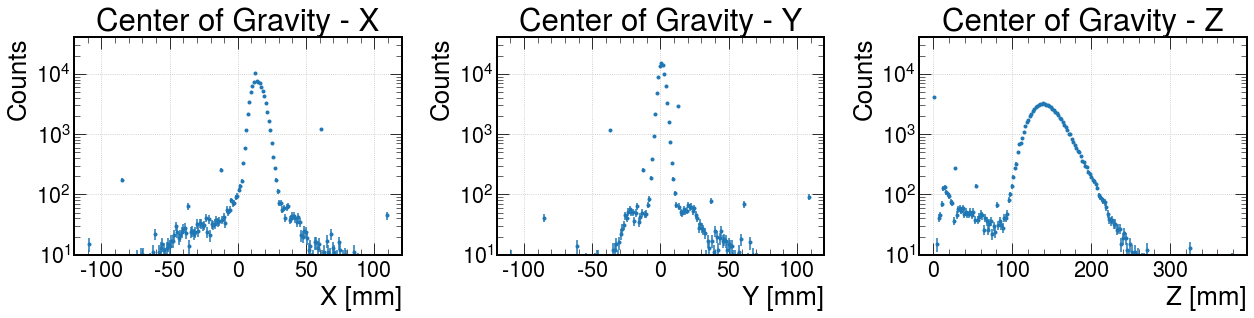

In [144]:
plot_cog(cog_data, bins=200)

In [78]:
high_indexes = []
for i in range(len(energies)):
    if(energies[i] > 50):
        high_indexes.append(i)

In [76]:
def plot_event_3d(beam_data, evtnum):
    positions = beam_data['positions']  # shape: (num_channels, 5)
    events = beam_data['events']        # list of arrays, each shape: (num_channels,)
    
    energies = events[evtnum]
    above_thresh = energies > e_cut
    
    # Extract x, y, z positions for valid hits
    xs = positions[above_thresh, 0]
    ys = positions[above_thresh, 1]
    zs = positions[above_thresh, 2]
    hits = energies[above_thresh]
    
    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(xs, zs, ys, c=hits, cmap='viridis', s=50)

    # Add colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label("Energy [MIP]")

    ax.set_xlabel("X [mm]", labelpad=15)
    ax.set_ylabel("Z [mm]", labelpad=15)
    ax.set_zlabel("Y [mm]", labelpad=15)
    ax.set_title(f"Event {evtnum}")
    ax.set_ylim(0,400)
    ax.set_xlim(-100,100)
    ax.set_zlim(-100,100)
    plt.subplots_adjust(right=0.85)
    plt.show()


plt.show()

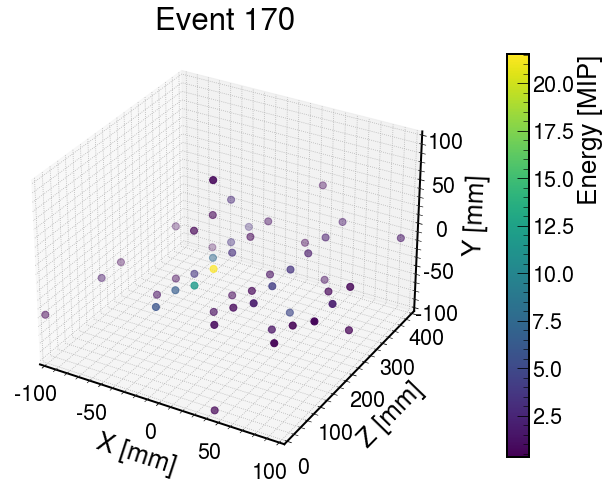

In [82]:
plot_event_3d(beam_data, high_indexes[4])

In [124]:
def plot_event_projections(beam_data, evtnum, threshold=0.3):
    positions = beam_data['positions']  # shape: (num_channels, 5)
    event = beam_data['events'][evtnum]  # shape: (num_channels,)

    # Filter hits above threshold
    mask = event > threshold
    energies = event[mask]
    pos_filtered = positions[mask]

    xs = pos_filtered[:, 0]  # x [mm]
    ys = pos_filtered[:, 1]  # y [mm]
    zs = pos_filtered[:, 2]  # z [mm]

    def plot_energy_projection(x, y, energy, xlabel, ylabel, title):
        df = pd.DataFrame({
            'x': x,
            'y': y,
            'energy': energy
        })

        grouped = df.groupby(['x', 'y'], as_index=False).sum()
        configure_plotting()
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(grouped['x'], grouped['y'], c=grouped['energy'],
                         cmap='viridis', s=80)
        plt.colorbar(sc, label='Energy [MIP]')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    plot_energy_projection(xs, ys, energies, 'X [mm]', 'Y [mm]', f'XY Projection - Event {evtnum}')
    plot_energy_projection(xs, zs, energies, 'X [mm]', 'Z [mm]', f'XZ Projection - Event {evtnum}')
    plot_energy_projection(ys, zs, energies, 'Y [mm]', 'Z [mm]', f'YZ Projection - Event {evtnum}')


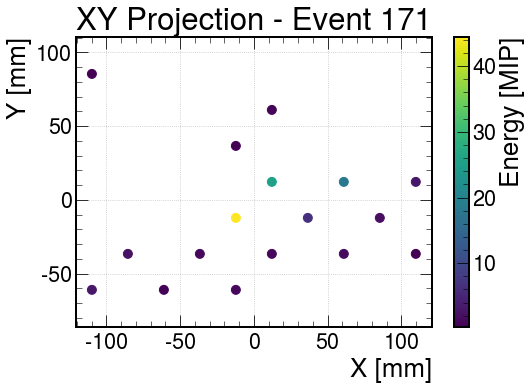

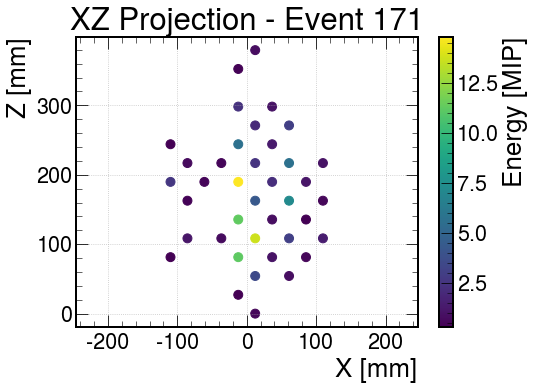

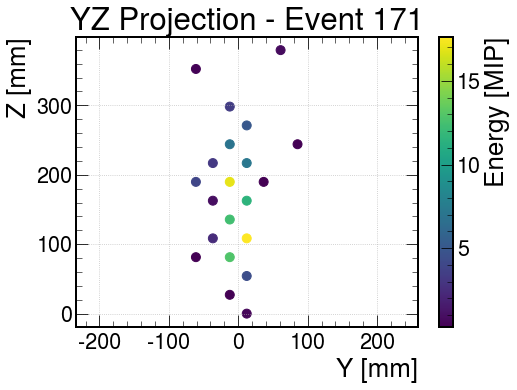

In [125]:
plot_event_projections(beam_data, evtnum=high_indexes[5])